In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



In [3]:
# Training dataset file to use. String expected
# training_file = "datasets/training_data_constrained.csv"
# training_file = "datasets/training_data_special2.csv"
# training_file = "datasets/jw_datasets/training_data_NND.csv"
# training_file = "datasets/jw_datasets/unique_config_train.csv"
# training_file = "datasets/training_data_special3.csv"
# training_file = "datasets/jw_datasets/unique_config_template.csv"
# training_file = "datasets/constrained.csv"
# training_file = "datasets/ncombined_train.csv"
training_file = "datasets/unor.csv"


testing_file = "datasets/attack.csv"
# testing_file = "datasets/special.csv"
# testing_file = "datasets/unconstrained.csv"

# testing_file = "datasets/testing_data_constrained.csv"
# testing_file = "datasets/jw_datasets/unique_config_vary_load_only.csv"
# testing_file = "datasets/constrained.csv"
# testing_file = "datasets/jw_datasets/unique_config_template.csv"

# testing_file = "datasets/jw_datasets/unique_config_test3.csv"
# testing_file = "datasets/jw_datasets/training_data_constrained_new.csv"
# testing_file = "datasets/jw_datasets/training_data_ncombined_new.csv"
# testing_file = "datasets/jw_datasets/ncombined_new.csv"


# testing_file = "datasets/testing_data_special3.csv"
# testing_file = "datasets/jw_datasets/testing_data_NCombined.csv"


In [4]:
training_data = pd.read_csv(training_file)
testing_data = pd.read_csv(testing_file)
training_data.head()
testing_data.describe()

,CB_0_closed,CB_1_closed,CB_2_closed,CB_3_closed,CB_4_closed,CB_5_closed,CB_6_closed,CB_7_closed,CB_8_closed,CB_9_closed,...,trafo_0_in_service,trafo_1_in_service,trafo_2_in_service,trafo_3_in_service,trafo_4_in_service,trafo_5_in_service,feeder_0_in_service,feeder_1_in_service,total_init_load,anomaly
count,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.0,262144.0,262144.0,...,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.0,262144.0,262144.000000,262144.000000
mean,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,1.0,1.0,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,1.0,5.921919,0.984375
std,0.500001,0.500001,0.500001,0.500001,0.500001,0.500001,0.500001,0.0,0.0,0.0,...,0.500001,0.500001,0.500001,0.500001,0.500001,0.500001,0.0,0.0,5.515480,0.124020
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,1.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,1.0,1.0,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.0,1.0,6.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,10.200000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,18.300000,1.000000


In [5]:
neg, pos = np.bincount(training_data['anomaly'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 45681
    Positive: 17184 (37.62% of total)



In [6]:
neg, pos = np.bincount(testing_data['anomaly'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 262144
    Positive: 258048 (98.44% of total)



In [7]:
training_data.fillna(0,inplace=True)

# Get features
X_train = training_data.drop(columns=['anomaly', 'reason'])
# X_train = training_data.drop(columns=['anomaly', "CB_151_closed", "CB_6_closed", "CB_1_closed"])

# Test using only Grid Configuration Features
# cols = list(range(34,70))
# X_train.drop(training_data.columns[cols],axis=1,inplace=True)
# Get labels
y_train = training_data['anomaly']

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train

,CB_0_closed,CB_1_closed,CB_2_closed,CB_3_closed,CB_4_closed,CB_5_closed,CB_6_closed,CB_7_closed,CB_8_closed,CB_9_closed,...,load_17::q,trafo_0_in_service,trafo_1_in_service,trafo_2_in_service,trafo_3_in_service,trafo_4_in_service,trafo_5_in_service,feeder_0_in_service,feeder_1_in_service,total_init_load
0,1,1,1,1,1,1,1,1,1,1,...,0.2345,1,1,1,1,1,1,1,1,8.366852
1,1,1,1,1,1,1,1,1,1,1,...,0.2345,1,1,1,1,1,1,0,1,8.366852
2,1,1,1,1,1,1,1,1,1,1,...,0.3427,1,1,1,1,1,1,1,1,26.670039
3,1,1,1,1,1,1,1,0,1,1,...,0.3427,1,1,1,0,1,1,1,1,26.670039
4,1,1,1,1,1,1,1,0,1,1,...,0.3427,1,1,1,0,1,1,0,1,26.670039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45676,1,1,1,1,1,0,0,1,1,1,...,0.4909,1,1,1,0,1,0,1,1,27.402741
45677,1,1,1,1,1,0,0,1,1,1,...,0.4909,0,1,1,0,1,0,1,0,27.402741
45678,1,1,1,1,1,0,0,1,1,1,...,0.7437,1,1,1,0,1,0,1,1,44.724670
45679,1,1,1,1,1,0,0,1,1,1,...,0.9834,1,1,1,0,1,0,1,1,57.213390


In [8]:
testing_data.fillna(0,inplace=True)

# Get features
X_test = testing_data.drop(columns=['anomaly', 'reason'])
# X_test = testing_data.drop(columns=['anomaly', 'reason'])
# X_test = testing_data.drop(columns=['anomaly', "CB_151_closed", "CB_6_closed", "CB_1_closed"])

# Test using only Grid Configuration Features
# cols = list(range(34,70))
# X_test.drop(testing_data.columns[cols],axis=1,inplace=True)

# Get labels
y_test = testing_data['anomaly']
X_test

,CB_0_closed,CB_1_closed,CB_2_closed,CB_3_closed,CB_4_closed,CB_5_closed,CB_6_closed,CB_7_closed,CB_8_closed,CB_9_closed,...,load_17::q,trafo_0_in_service,trafo_1_in_service,trafo_2_in_service,trafo_3_in_service,trafo_4_in_service,trafo_5_in_service,feeder_0_in_service,feeder_1_in_service,total_init_load
0,1,1,1,1,1,1,1,1,1,1,...,0.3,1,1,1,1,1,1,1,1,18.3
1,1,1,1,1,1,1,1,1,1,1,...,0.3,1,1,1,1,1,1,1,1,18.3
2,1,1,1,1,1,1,1,1,1,1,...,0.3,1,1,1,1,1,0,1,1,18.3
3,1,1,1,1,1,1,1,1,1,1,...,0.3,1,1,1,1,0,1,1,1,18.3
4,1,1,1,1,1,1,1,1,1,1,...,0.0,1,1,1,1,0,0,1,1,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,1,1,1,0,0,0,0,1,1,1,...,0.0,1,0,1,0,0,1,1,1,7.2
262140,1,1,1,0,0,0,0,1,1,1,...,0.0,1,0,1,0,0,0,1,1,7.2
262141,1,1,1,0,0,0,0,1,1,1,...,0.0,1,0,1,0,0,0,1,1,7.2
262142,1,1,1,0,0,0,0,1,1,1,...,0.0,1,0,1,0,0,1,1,1,7.2


In [9]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

np.random.seed(5)

best_params = {'colsample_bytree': 0.5,
 'gamma': 2,
 'learning_rate': 0.5,
 'max_depth': 15,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'random_state': 42
 }
print(best_params)
final_cl = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    seed=42
    )

# best_params = {
#     'n_estimators': 300,
#     'max_depth': 10,
#     'max_features': 'auto'
# }
# final_cl = RandomForestClassifier(**best_params)
# print(final_cl)

# best_params = {
#     'min_samples_leaf': 1,
#     'max_depth': 8,
#     'max_features': 'auto'
# }		
# final_cl = DecisionTreeClassifier(**best_params)

final_cl.fit(X_train, y_train)


{'colsample_bytree': 0.5, 'gamma': 2, 'learning_rate': 0.5, 'max_depth': 15, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'random_state': 42}


C:\Users\Jiawe\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.8, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, ...)

In [10]:
preds = final_cl.predict(X_test)

In [8]:
import sklearn
print(sklearn.utils.check_random_state(None))
print(np.random.get_state()[1][0])
print(preds)
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print(sys.version)


RandomState(MT19937)
5
[0 0 0 ... 1 1 1]
The scikit-learn version is 0.22.1.
3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]


In [11]:
# Calculate and print statistics
TN, TP, FN, FP = 0, 0, 0, 0
TP_list = []
TN_list = []
FN_list = []
FP_list = []
# print(y_test)
# y_test = y_test.values.tolist()
for i in range(len(y_test)):
    if y_test[i]==0:
        if preds[i]==0: 
            TN += 1
            TN_list.append(i)
        else: 
            FP += 1
            FP_list.append(i)
    else:
        if preds[i]==0: 
            FN += 1
            FN_list.append(i)
        else: 
            TP += 1
            TP_list.append(i)

print("TN", TN, "TP", TP, "FN", FN, "FP", FP)
print("Accuracy: {}%".format((TN+TP)*100/(TN+TP+FN+FP)))

#  Calculate and print precision, recall and F1 score
precision = 0 if TP+FP==0 else TP/(TP+FP)
recall = 0 if TP+FP==0 else TP/(TP+FN)
fscore = 0 if precision+recall==0 else 2*precision*recall/(precision+recall)

print("Overall statistics:")
print("\tPrecision: {}".format(precision))
print("\tRecall: {}".format(recall))
print("\tF1 score: {}".format(fscore))

TN 4096 TP 256456 FN 1592 FP 0
Accuracy: 99.3927001953125%
Overall statistics:
	Precision: 1.0
	Recall: 0.9938306051587301
	F1 score: 0.9969057577783651


<AxesSubplot:>

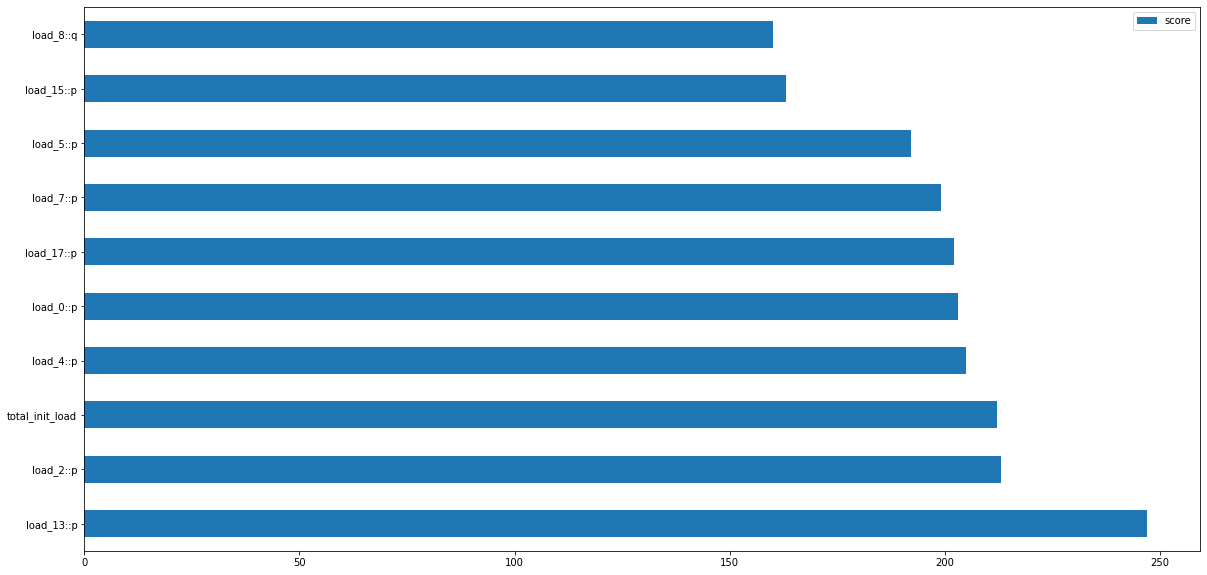

In [14]:
feature_important = final_cl.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [13]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(final_cl)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

AttributeError: module 'shap' has no attribute 'Explainer'

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])


In [ ]:
shap.plots.force(shap_values[0:1000])


In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
# temp_param = {}
# max_recall = 0
# for k in range(0,6):
#     for j in range(0, 6):
#     # Insert the new fixed values to the grid
#         temp_param["scale_pos_weight"] = 1
#         temp_param["subsample"] = 0.8
#         temp_param["colsample_bytree"] = 0.5

#         # Give new value ranges to other params
#         temp_param["gamma"] = param_grid["gamma"][j]
#         temp_param["max_depth"] = param_grid["max_depth"][k]
#         temp_param["reg_lambda"] = param_grid["reg_lambda"][k]
#         temp_param["learning_rate"] = param_grid["learning_rate"][k]
        
#         print(temp_param)

#         temp_cl = xgb.XGBClassifier(
#             **best_params,
#             objective="binary:logistic",
#         )

#         temp_cl.fit(X_train, y_train)
#         preds = temp_cl.predict(X_test)

#         # Calculate and print statistics
#         TN, TP, FN, FP = 0, 0, 0, 0

#         for i in range(len(y_test)):
#             if y_test[i]==0:
#                 if preds[i]==0: TN += 1
#                 else: FP += 1
#             else:
#                 if preds[i]==0: FN += 1
#                 else: TP += 1

#         print("TN", TN, "TP", TP, "FN", FN, "FP", FP)
#         print("Accuracy: {}%".format((TN+TP)*100/(TN+TP+FN+FP)))

#         #  Calculate and print precision, recall and F1 score
#         precision = 0 if TP+FP==0 else TP/(TP+FP)
#         recall = 0 if TP+FP==0 else TP/(TP+FN)
#         fscore = 0 if precision+recall==0 else 2*precision*recall/(precision+recall)

#         print("Overall statistics:")
#         print("\tPrecision: {}".format(precision))
#         print("\tRecall: {}".format(recall))
#         print("\tF1 score: {}".format(fscore))

#         if recall > max_recall:
#             best_params = temp_param
# print(best_params)

In [ ]:
print("False Negatives Data:")
print(len(FN_list))
print(FN_list)

print("False Positive Data:")
print(len(FP_list))
print(FP_list)

In [ ]:
df_FN = testing_data.iloc[FN_list]
df_FN.describe()

In [ ]:
df_TN = testing_data.iloc[TN_list]
df_TN.describe()

In [ ]:
df_TN_temp = df_TN.head(280).reset_index(drop=True)
df_FN_temp = df_FN.reset_index(drop=True)
df_compare = df_FN_temp.compare(df_TN_temp)
df_compare.head()

In [ ]:
columns = df_TN.columns
NaN_dict = {}
NaN_count = 0

for i in range(0,len(columns)):
    try:
        NaN_count = 280 - int(df_compare[columns[i]].value_counts()[0][1]) - int(df_compare[columns[i]].value_counts()[1][0])
        NaN_dict[columns[i]] = NaN_count
    except Exception as E:
        continue
print(NaN_dict)
{k: v for k, v in sorted(NaN_dict.items(), key=lambda item: item[1])}

In [ ]:
df_TP = testing_data.iloc[TP_list]
df_TP.describe()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

#get correlations of each features in dataset
corrmat = df_FN.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(100,100))
#plot heat map
g=sns.heatmap(df_FN[top_corr_features].corr(),annot=True,cmap="RdYlGn")